In [5]:
# 최대 분산 효과 포트폴리오
# 참고 : http://henryquant.blogspot.com/search/label/Programming?updated-max=2018-02-15T18:45:0%2B09:00&max-results=1&pgno=8
# 참고 : https://hyunyulhenry.github.io/quant_cookbook/%ED%8F%AC%ED%8A%B8%ED%8F%B4%EB%A6%AC%EC%98%A4-%EA%B5%AC%EC%84%B1.html
# 상관관계가 낮아질수록 포트폴리오의 변동성 또한 낮아짐. 이를 분산효과라고 함
# 분산효과의 정도를 측정하는 지표인 분산비율(DR : Diversification Ratio) : Sum(w_i*sigma_i)/sigma_p
# 자산간 상관관계가 낮을 수록 분산효과로 인해 포트폴리오의 변동성은 낮아지고, 분산 비율은 점점 커짐
# 구현하는 3가지 방식
# (1) Choueifaty Synthetic Asset Back-Transformation 이용 : 즉, DR을 최대화 하는 값은 w'Cw를 최소화 하는 것과 같음. 
# 그리고 real portfolio로 transformation 해주기 위해 weight를 각각의 volatility로 나누어 주어야 합니다.
# 1.1 w'Cw가 최소화가 되는 weight를 구함 1.2 구해진 weight를 각 종목들의 sigma로 나눠줌 1.3 합이 1이 되도록 스케일 해줌
# (2) Duality 이용 : 요런저런 테크닉은 쓰면 MDP의 수식은 min w'Σw, 즉 포트폴리오의 변동성을 최소화하는 최소분산 포트폴리오에
# 개별종목 변동성의 가중합이 1이라는 제약조건을 추가하면 됩니다.
# (3) 사실 MDP는 DR을 최대화 하는 방법입니다. 그렇다면 이는 그냥 -DR를 최소화 하는 것과 같습니다.
# 여기서는 2번방식으로 구현해보겠다.

import numpy as np
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import FinanceDataReader as fdr
import scipy.optimize as sco

def statistics(weights):

    weights=np.array(weights)
    returns = np.dot(weights, annual_ret) 
    risk = np.sqrt(np.dot(weights.T, np.dot(annual_cov, weights)))
    # 무위험 수익률은 0이라 가정 
    sharpe_ratio = returns/risk

    return np.array([returns, risk, sharpe_ratio])



In [6]:
stocks = ['삼성전자', 'SK하이닉스', '삼성바이오로직스', 'NAVER', '셀트리온']

# SQLite3 DB 불러오기
con = sqlite3.connect('C:\\Users\\inventor\\Desktop\\FR study\\상장법인목록.db')
code_data = pd.read_sql("SELECT * FROM CorpList", con)
con.close()

code_data = code_data[['종목코드', '기업명']]
code_data = code_data.rename(columns={'기업명': 'name', '종목코드': 'code'})

# 회사명으로 주식 종목 코드를 획득할 수 있도록 하는 함수
def get_code(df, name):

    #query로 name(회사명)이 파라미터로 넘겨준 name과 같으면 code열에서 종목코드 찾고 스트링으로 출력하는데 인덱스 번호 빼고 출력(false)
    code = df.query("name=='{}'".format(name))['code'].to_string(index=False)
    # 위와같이 code명을 가져오면 앞에 공백이 붙어있는 상황이 발생하여 앞뒤로 strip() 하여 공백 제거
    code = code.strip()
    return code


df = pd.DataFrame()

for s in stocks:
    code = get_code(code_data, s)
    df[s] = fdr.DataReader(code, '2015-01-01')['Close']


df

삼성전자  SK하이닉스  삼성바이오로직스   NAVER    셀트리온
Date                                               
2015-01-02  26600   47750       NaN  146408   35532
2015-01-05  26660   47650       NaN  150013   35350
2015-01-06  25900   47500       NaN  148811   34715
2015-01-07  26140   47400       NaN  146608   34397
2015-01-08  26280   49950       NaN  149011   34579
...           ...     ...       ...     ...     ...
2020-07-24  54200   83700  755000.0  281000  319000
2020-07-27  55600   82800  754000.0  284500  317000
2020-07-28  58600   83100  761000.0  288000  317500
2020-07-29  59000   83200  741000.0  292000  301500
2020-07-30  59000   85300  736000.0  294000  300000

[1372 rows x 5 columns]

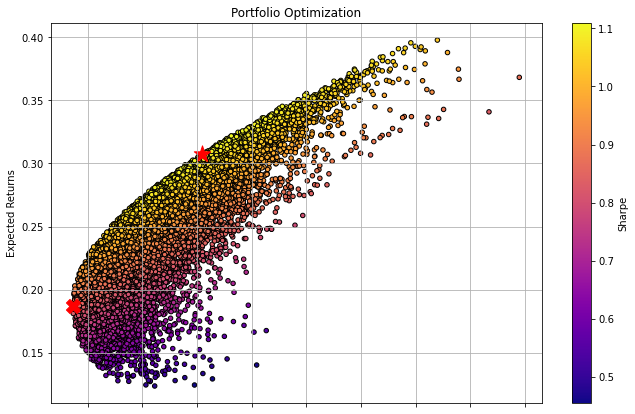

In [7]:
daily_ret = np.log(df.pct_change()+1)
daily_ret.dropna()
annual_ret = daily_ret.mean() * 252
daily_cov = daily_ret.cov()
annual_cov = daily_cov * 252

port_ret = [] 
port_risk = [] 
port_weights = [] 
sharpe_ratio = [] 

np.random.seed(0)
for _ in range(20000): 
    weights = np.random.random(len(stocks)) 
    weights /= np.sum(weights) 

    returns = np.dot(weights, annual_ret) 
    risk = np.sqrt(np.dot(weights.T, np.dot(annual_cov, weights))) 

    port_ret.append(returns) 
    port_risk.append(risk) 
    port_weights.append(weights)
    sharpe_ratio.append(returns/risk)  # 단순화를 위해 rf=0 이라 가정

portfolio = {'Returns': port_ret, 'Risk': port_risk, 'Sharpe': sharpe_ratio}
for i, s in enumerate(stocks): 
    portfolio[s] = [weight[i] for weight in port_weights] 
df = pd.DataFrame(portfolio) 
df = df[['Returns', 'Risk', 'Sharpe'] + [s for s in stocks]] 

max_sharpe = df.loc[df['Sharpe'] == df['Sharpe'].max()]
min_risk = df.loc[df['Risk'] == df['Risk'].min()]


df.plot.scatter(x='Risk', y='Returns', c='Sharpe', cmap='plasma',
    edgecolors='k', figsize=(11,7), grid=True)  
plt.scatter(x=max_sharpe['Risk'], y=max_sharpe['Returns'], c='r', 
    marker='*', s=300)  
plt.scatter(x=min_risk['Risk'], y=min_risk['Returns'], c='r', 
    marker='X', s=200)  
plt.title('Portfolio Optimization') 
plt.xlabel('Risk') 
plt.ylabel('Expected Returns') 
plt.show()

In [10]:
# 포트폴리오의 분산 최소화에 개별 변동성의 가중합이 1이 제한조건인 최대분산효과 포트폴리오
def min_func_variance(weights):
    return statistics(weights)[1]**2

cons = ({'type':'eq', 'fun':lambda x:np.sum(np.sqrt(np.diag(annual_cov))*x)-1})
lbound  = np.repeat(0, len(stocks))
ubound  = np.repeat(float("inf"), len(stocks))
bnds = tuple(zip(lbound, ubound))

options = {'ftol': 1e-20, 'maxiter': 800}
initial_weights = len(stocks)*[1./len(stocks)]

optvs = sco.minimize(min_func_variance, initial_weights, method='SLSQP', bounds=bnds, constraints=cons, options=options)

In [11]:
optvs

     fun: 0.37959785217621506
     jac: array([0.20461617, 0.27416987, 0.36324628, 0.25613823, 0.37285882])
 message: 'Optimization terminated successfully.'
    nfev: 290
     nit: 29
    njev: 29
  status: 0
 success: True
       x: array([0.6085187 , 0.48322055, 0.42289047, 0.73341118, 0.43107577])

In [14]:
# 비중이 현재 1을 초과함. 따라서 비중의 합이 1이 되도록 표준화
optvs['x']=optvs['x']/np.sum(optvs['x'])
statistics(optvs['x'].round(3))

array([0.22182539, 0.22999239, 0.96449013])

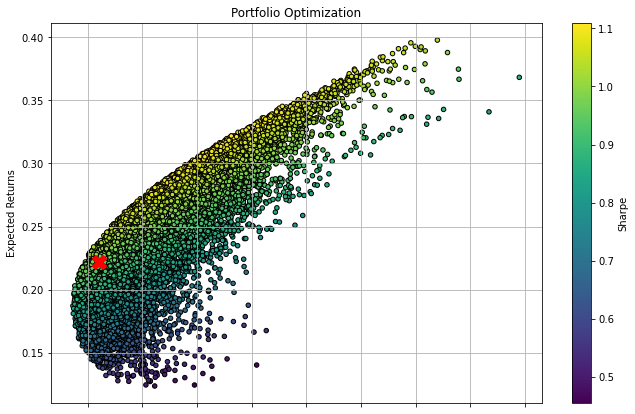

In [15]:
# 무작위 포트폴리오
df.plot.scatter(x='Risk', y='Returns', c='Sharpe', cmap='viridis',
    edgecolors='k', figsize=(11,7), grid=True) 

# 최대 분산 효과 포트폴리오 
plt.scatter(x=statistics(optvs['x'])[1], y=statistics(optvs['x'])[0], c='r', 
    marker='X', s=200)  
plt.title('Portfolio Optimization')
plt.xlabel('Risk') 
plt.ylabel('Expected Returns') 
plt.show()